<h2>Community Board Budget Requests Classification</h2>
<h2>Group Member: Yifan Wang (yw3581)</h2>

<span style="color:green;font-size:xx-large">Introduction</span>

Using the dataset <a href="https://data.cityofnewyork.us/City-Government/Register-of-Community-Board-Budget-Requests/vn4m-mk4t">Community Board Budget Requests</a> containing explanation of project and program requests from the city’s community boards to the NYC Office of Management and Budget (OMB), this project aims at studying the relationship between these requests’ explanations and the responsible agency(department) OMB assigned to them. The result of this project can be used by OMB for auto classification of future requests to help them find their responsible agencies and accordingly reduce the workload for OMB.
    
The general pipeline of this project is:
    

* **Step 1: Sample and Feature Selection:** narrow down the dataset to 3 features: 'Explanation ', 'Responded By' and 'Responsible Agency'. Keep samples responded by OMB and assigned agency lies in the top 9 agencies with the most recorded samples.  
* **Step 2: Exploratory data analysis:** study the most frequent words, bigrams, coreferences in the explanations of request to each agency.
* **Step 3: Imbalanced Dataset Oversampling:** this dataset is imbalanced and there is a severe skew in the distribution of the 9 selected classes, it varies from 200 to around 1000 samples from the minority class to the majority class. Thus, I used oversampling to make each class balanced.
* **Step 4: Feature Extraction and Classification Model Training:** TF-IDF and word imbedding are applied for text feature extraction and Naive Bayes, Support Vector Machine, Multiclass Logistic Regression and CNN+LSTM are used for classification.
* **Step 5: Model Evaluation**
* **Step 6: Combine 4 Models and Make Agency Predictions for New Requests**
    


<span style="color:green;font-size:xx-large">Libraries Importing</span>

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import operator
import string
import os
import spacy
import re
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import imblearn
import collections
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

In [3]:
#nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
import itertools

[nltk_data] Downloading package punkt to /Users/wangyifan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wangyifan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#coreference_resolution
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging
coreference_resolution = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz")

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
#sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder

In [46]:
#tensorflow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os, struct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

Instructions for updating:
non-resource variables are not supported in the long term


In [55]:
#Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten,MaxPooling1D,LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

<span style="color:green;font-size:xx-large">Sample and Feature Selection</span>

In [6]:
#read data
df=pd.read_csv('data.csv')

/Users/wangyifan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
#check information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42957 entries, 0 to 42956
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Publication         42957 non-null  int64  
 1   Borough             42957 non-null  int64  
 2   Community Board     42957 non-null  int64  
 3   Priority            42957 non-null  object 
 4   Tracking  Code      42957 non-null  object 
 5   Request             42957 non-null  object 
 6   Explanation         42751 non-null  object 
 7   Response            42957 non-null  object 
 8   Responded By        42957 non-null  object 
 9   Responsible Agency  42957 non-null  object 
 10  Support by 1        8273 non-null   object 
 11  Support by 2        3486 non-null   object 
 12  Site Street         2203 non-null   object 
 13  Cross Street 1      4773 non-null   object 
 14  Cross Street 2      4401 non-null   object 
 15  Number              1738 non-null   object 
 16  Stre

In [8]:
len(df)

42957

In [9]:
#select necessary features
df = df[['Explanation ','Responded By','Responsible Agency']]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42957 entries, 0 to 42956
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Explanation         42751 non-null  object
 1   Responded By        42957 non-null  object
 2   Responsible Agency  42957 non-null  object
dtypes: object(3)
memory usage: 1006.9+ KB


In [11]:
#drop duplicate rows
df = df.drop_duplicates(subset=['Explanation ', 'Responsible Agency'], keep='last')

In [12]:
#drop nan value
df = df.dropna()

In [13]:
len(df)

9844

In [14]:
#only keep requests responded by OMB
#df.groupby('Responded By').count()
df = df[df['Responded By'] == 'OMB']

In [15]:
len(df)

6062

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6062 entries, 880 to 39230
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Explanation         6062 non-null   object
 1   Responded By        6062 non-null   object
 2   Responsible Agency  6062 non-null   object
dtypes: object(3)
memory usage: 189.4+ KB


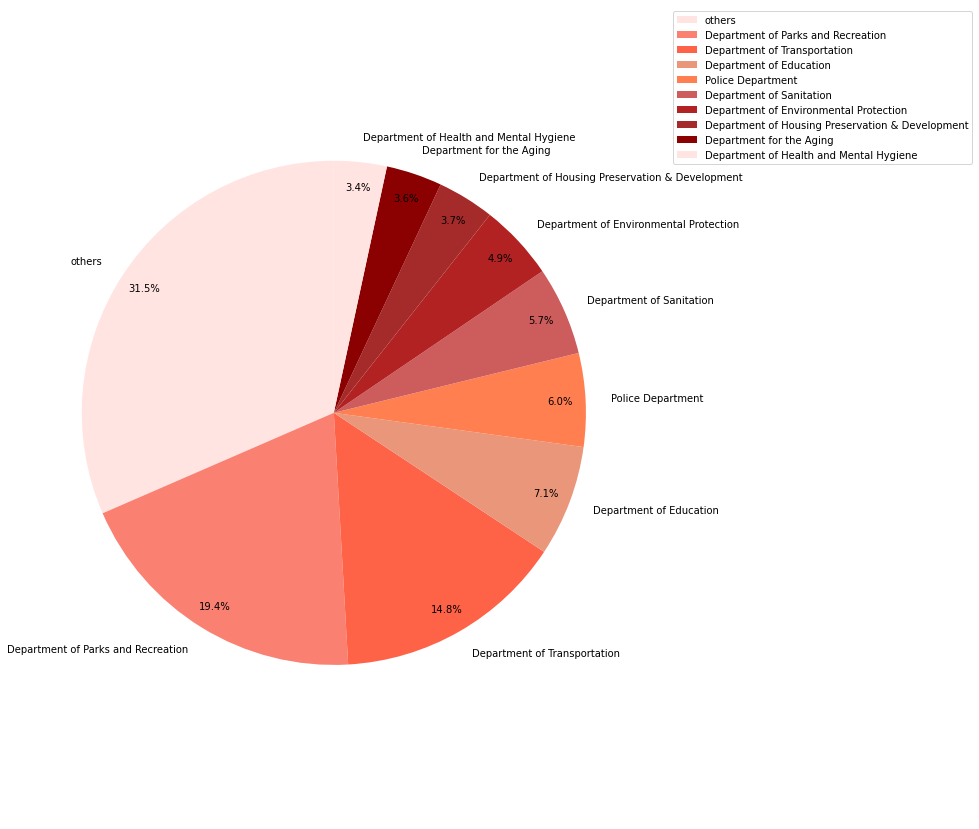

In [17]:
#Draw pie chart of agency
agency = df.groupby('Responsible Agency').size()
agency.loc['others'] = agency[agency<200].sum()
agency = agency.sort_values(ascending=False)
agency = agency[agency>=200]
agency_name = agency.index.tolist()
agency_size = agency.tolist()
labels = agency_name
sizes =  agency_size
colors = ['mistyrose','salmon','tomato','darksalmon','coral','indianred','firebrick','brown','darkred']
fig1, ax1 = plt.subplots(figsize=(10,15))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors = colors, pctdistance = 0.9)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 0.,0.4, 1))
plt.show()

**The pie chart shows that there are 9 classes have samples over 200 and they account for 68.5% of the dataset in total. For the purpose of having sufficient sample for model training in each class, samples that lies in these 9 classes are kept which are Department for the Aging, Department of Education,Department of Environmental Protection, Department of Health and Mental Hygiene, Department of Housing Preservation & Development, Department of Parks and Recreation, Department of Sanitation, Department of Transportation, Police Department.**

In [18]:
#agency_list
agency_list = df.groupby('Responsible Agency').size().sort_values(ascending=False).index.tolist()[0:9]

#observe the responsible agency distribution, keep only the top 9 agencies.
df = df[df['Responsible Agency'].isin(agency_list)]


<span style="color:green;font-size:xx-large">EDA - Most Frequent Words for each Agency</span>

**In this part the stopwords and the words that are too short or long will be filtered out and then the frquency of each word will be counted and the most frequent 10 words in the requests assigned to each department are reported.**

In [19]:
#build a new dataframe that join all the request text of each agency together
df_exp = df.groupby('Responsible Agency').agg({'Explanation ':lambda x:x.str.cat(sep='.')})

In [20]:
translator=str.maketrans('','',string.punctuation)
def word_count(content): 
    all_words = list()
    sentences = nltk.sent_tokenize(content)  
    #remove stop words and short/long words
    for sentence in sentences:
        sentence = sentence.strip()
        sent_words = nltk.word_tokenize(sentence)
        sent_words = [word for word in sent_words if ((len(word.translate(translator)) > 1) and (len(word) < 20))]
        sent_words = [word for word in sent_words if word.lower() not in stopwords_list]
        for word in sent_words:
            word = word.lower()  
            word=word.translate(translator)
            all_words.append(word)
    #count the frequency of each word
    words_dic = dict()
    for i in all_words:
        if i in words_dic:
            words_dic[i] += 1
        else: 
            words_dic[i] = 1
    #return the top 10 frquent words appears in the request for each agency
    words_dic = dict(sorted(words_dic.items(), key=lambda item: item[1],reverse=True)[:10])
    return words_dic

In [21]:
df_exp['word_count'] = df_exp['Explanation '].apply(lambda x: word_count(x))

In [22]:
df_exp.reset_index()[['Responsible Agency','word_count']]

,Responsible Agency,word_count
0,Department for the Aging,"{'senior': 179, 'funding': 125, 'services': 121, 'seniors': 119, 'programs': 82, 'centers': 79, 'center': 63, 'increase': 59, 'community': 55, 'program': 55}"
1,Department of Education,"{'school': 345, 'schools': 174, 'students': 154, 'funding': 133, 'new': 116, 'district': 108, 'high': 106, 'provide': 98, 'need': 87, 'ps': 84}"
2,Department of Environmental Protection,"{'avenue': 199, 'street': 173, 'sewer': 122, 'flooding': 103, 'water': 102, 'catch': 100, 'basins': 96, 'storm': 92, 'sewers': 76, 'area': 66}"
3,Department of Health and Mental Hygiene,"{'health': 141, 'community': 77, 'mental': 65, 'district': 56, 'programs': 53, 'education': 52, 'funding': 47, 'services': 46, 'increase': 46, 'residents': 42}"
4,Department of Housing Preservation & Development,"{'housing': 276, 'affordable': 134, 'funding': 75, 'hpd': 70, 'community': 69, 'units': 58, 'income': 57, 'residents': 51, 'programs': 48, 'city': 47}"
5,Department of Parks and Recreation,"{'park': 990, 'parks': 415, 'playground': 384, 'community': 271, 'street': 266, 'funding': 251, 'need': 249, 'new': 200, 'area': 180, 'additional': 172}"
6,Department of Sanitation,"{'district': 119, 'street': 114, 'sanitation': 103, 'community': 101, 'additional': 95, 'collection': 87, 'avenue': 74, 'increase': 74, 'basket': 73, 'commercial': 72}"
7,Department of Transportation,"{'street': 692, 'avenue': 561, 'traffic': 376, 'ave': 241, 'pedestrian': 226, 'streets': 208, 'st': 198, 'safety': 166, 'road': 159, 'need': 129}"
8,Police Department,"{'precinct': 218, 'officers': 148, 'street': 132, 'additional': 116, 'police': 109, 'community': 105, 'avenue': 105, 'traffic': 82, 'new': 75, 'increase': 67}"


**We extracted some characteristic words for each department. For example, the word that appears the most frequently in the requests assigned to Department for the Aging is senior, the word that appears the most frequently in the requests assigned to Department of Education is school.**

<span style="color:green;font-size:xx-large">EDA - Most Frequent Bigrams for each Agency¶</span>

**Bigrams are two words coming together in the entire collection. In this part the stopwords and the words that are too short or long will be filtered out and then the frquency of each bigram will be counted and the most frequent 10 bigrams in the requests assigned to each department are reported.**

In [23]:
#tokenize each sentence in each request 
def clean_bigram(content):  

    tokenized_sentences = list()
   
    sentences = nltk.sent_tokenize(content)  
    for sentence in sentences:
        sentence = sentence.strip()
        tokenized_sent = list()
        sent_words = nltk.word_tokenize(sentence)
        #filter out stop words and too short/long words
        sent_words = [word for word in sent_words if ((len(word.translate(translator)) > 1) and (len(word) < 20))]
        sent_words = [word for word in sent_words if word.lower() not in stopwords_list]
        for word in sent_words:
            word = word.lower()
            word=word.translate(translator)
            tokenized_sent.append(word)
        tokenized_sentences.append(tokenized_sent)
    return tokenized_sentences

In [24]:
df_exp['tokenized'] = df_exp['Explanation '].apply(lambda x: clean_bigram(x))

In [25]:
#generate bigrams for each sentence and count their frequencies
def bigrams(tokenized):
    bigram_list = list(itertools.chain (*[nltk.bigrams(sent) for sent in tokenized]))
    bigram_dic = dict()
    for i in bigram_list:
        if i in bigram_dic:
            bigram_dic[i] += 1
        else: 
            bigram_dic[i] = 1
    bigram_dic = dict(sorted(bigram_dic.items(), key=lambda item: item[1],reverse=True)[0:10])
    return bigram_dic



In [26]:
df_exp['bigrams'] = df_exp['tokenized'].apply(lambda x: bigrams(x))

In [27]:
df_exp.reset_index()[['Responsible Agency','bigrams']]

,Responsible Agency,bigrams
0,Department for the Aging,"{('senior', 'centers'): 63, ('senior', 'center'): 35, ('increase', 'funding'): 25, ('meals', 'wheels'): 14, ('senior', 'population'): 14, ('funding', 'senior'): 13, ('additional', 'funding'): 13, ('senior', 'services'): 13, ('older', 'adults'): 13, ('home', 'care'): 12}"
1,Department of Education,"{('high', 'school'): 71, ('school', 'district'): 31, ('provide', 'funding'): 30, ('high', 'schools'): 19, ('staten', 'island'): 18, ('public', 'schools'): 16, ('public', 'school'): 15, ('capital', 'plan'): 15, ('community', 'district'): 14, ('increase', 'funding'): 14}"
2,Department of Environmental Protection,"{('catch', 'basins'): 89, ('storm', 'water'): 26, ('sewer', 'system'): 26, ('green', 'infrastructure'): 23, ('sanitary', 'sewers'): 22, ('community', 'board'): 20, ('sewer', 'lines'): 20, ('storm', 'sewers'): 19, ('storm', 'sewer'): 16, ('basins', 'sanitary'): 14}"
3,Department of Health and Mental Hygiene,"{('mental', 'health'): 40, ('health', 'issues'): 15, ('healthy', 'food'): 12, ('mental', 'illness'): 12, ('department', 'health'): 12, ('new', 'york'): 11, ('per', '100000'): 10, ('provide', 'funding'): 9, ('food', 'options'): 9, ('throughout', 'district'): 9}"
4,Department of Housing Preservation & Development,"{('affordable', 'housing'): 83, ('code', 'enforcement'): 20, ('supportive', 'housing'): 16, ('senior', 'housing'): 12, ('loan', 'programs'): 12, ('increase', 'funding'): 11, ('housing', 'stock'): 11, ('community', 'board'): 11, ('affordable', 'units'): 10, ('enforcement', 'inspectors'): 9}"
5,Department of Parks and Recreation,"{('comfort', 'station'): 104, ('riverside', 'park'): 48, ('parks', 'department'): 41, ('basketball', 'courts'): 38, ('recreation', 'center'): 38, ('parks', 'recreation'): 35, ('play', 'equipment'): 33, ('community', 'board'): 33, ('playground', 'west'): 32, ('parks', 'playgrounds'): 30}"
6,Department of Sanitation,"{('illegal', 'dumping'): 32, ('community', 'board'): 31, ('basket', 'collection'): 23, ('litter', 'baskets'): 21, ('litter', 'basket'): 21, ('sanitation', 'garage'): 19, ('commercial', 'strips'): 18, ('commercial', 'corridors'): 17, ('sanitation', 'enforcement'): 15, ('additional', 'basket'): 14}"
7,Department of Transportation,"{('pedestrian', 'vehicular'): 47, ('community', 'board'): 38, ('heavily', 'travelled'): 37, ('catch', 'basins'): 33, ('conditions', 'exist'): 33, ('road', 'conditions'): 32, ('allocate', 'funds'): 31, ('street', 'lighting'): 30, ('conjunction', 'dep'): 29, ('flooding', 'hazardous'): 29}"
8,Police Department,"{('police', 'officers'): 26, ('precinct', 'house'): 19, ('quality', 'life'): 19, ('police', 'precinct'): 19, ('surveillance', 'cameras'): 18, ('66th', 'precinct'): 17, ('crossing', 'guards'): 17, ('traffic', 'enforcement'): 17, ('assign', 'additional'): 17, ('community', 'board'): 14}"


**We extracted some representative bigrams in the request for each agency. Different from the simple word count in the last part, now we can see what the budgets applied in requests are used for. For example, many the requests that are assigned to the Department of Education are used for 'public high school'. Also, we can see 'mental heath' is a serious problem now as many requests are about it. OMB can use this information to see what the requests are about and what the budgets are for in general.**

<span style="color:green;font-size:xx-large">EDA - Coreference Resolution for each Agency</span>

**Coreference Resolution solve the task of grouping spans of text that refer to a single underlying entity or a single event. For example, in "my friend said she will go to that party", "my friend" and "she" refer to the same person. Using this method, top entities sorted based on the number of mentions across all requests originating from each agency is reported.**

In [28]:
def cleaning_cr(x):
    clean = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x)
    #REMOVE SPACE MORE THAN ONE
    clean = re.sub(' +', ' ', clean)
    return clean
df_cr=df.copy()
df_cr['exp_clean_cr'] = df['Explanation '].apply(cleaning_cr)

In [29]:
#generate new
def get_resol_dic(x):

    try:
        cr_result = coreference_resolution.predict(document=x)
        word_list = cr_result['document']
        entity_dic = dict()
        for cluster in cr_result['clusters']:
            first_mention = [word_list[word] for word in 
                                range(cluster[0][0],cluster[0][1]+1)]
            
            entity = ' '.join(first_mention)
            count=len(cluster)
            entity_dic[entity]=count
    except:
        return None

    return entity_dic

In [30]:
agency_list = list(pd.get_dummies(df['Responsible Agency']))
agency_list

['Department for the Aging',
 'Department of Education',
 'Department of Environmental Protection',
 'Department of Health and Mental Hygiene',
 'Department of Housing Preservation & Development',
 'Department of Parks and Recreation',
 'Department of Sanitation',
 'Department of Transportation',
 'Police Department']

In [33]:
for a in agency_list:
    df1 = df_cr[df_cr['Responsible Agency']==a]
    #keep 70 samples for each department for coreference resolution analysis 
    #due to the computation capacity limitation
    df1 = df1.sample(frac=70/len(df1),random_state=42)
    df1['cr_dic'] = df1['exp_clean_cr'].apply(get_resol_dic)
    bl_ent_dic=dict()
    for index, row in df1.iterrows():
        dic = row['cr_dic']
        if dic == None:
            continue
        else:
            for i in dic:
                if i not in bl_ent_dic:
                    bl_ent_dic[i]=dic[i]
                else:
                    bl_ent_dic[i]+=dic[i]
    sorted_dic = dict(sorted(bl_ent_dic.items(), key=lambda item: item[1],reverse=True)[0:10])
    print("Most Frequent References for ", a ," are: ", sorted_dic)
    print('\n')

Most Frequent References for  Department for the Aging  are:  {'Our seniors': 7, 'We': 6, 'DFTA': 6, 'Bay Ridge Center for Older Adults Senior Center The Bay Ridge Center for Older Adults': 5, 'seniors': 4, 'our senior population': 4, 'our elders': 4, 'senior centers': 4, 'people': 4, 'Many of the elderly': 3}


Most Frequent References for  Department of Education  are:  {'Students in poorly performing schools': 6, 'PS 116': 6, 'the building': 5, 'our youth': 5, 'the I S 93 Q Main School Building located at 66 56 Forest Avenue in Ridgewood': 4, 'SCA': 4, 'The DOE SCA 2020 24 Capital Plan': 4, 'ensure': 4, 'DoE': 3, 'MS 61': 3}


Most Frequent References for  Department of Environmental Protection  are:  {'We': 7, 'Flatbush Avenue': 6, 'Bay Ridge Avenue': 6, 'CB5Q': 5, 'our': 4, 'environ al': 4, 'such practices and values': 4, 'a permanent site in the Gowanus watershed area proximate to the canal': 4, 'both Sheepshead Bay and Gerritsen Creek': 4, '176th St between Murdock Ave and Sayre

**Instead of counting the frequency of single word or bigram, each entity mentioned in the requests and its frquency is printed in full. Although some stopwords are included, we can still see some important information. For example, 'The 52nd Precinct' may be an unsafe place and more security forces are needed according to the requests for Police Department. Additionally, There may be some factories that are not environment friendly located in Flatbush Avenue and Bay Ridge Avenue.**

<span style="color:green;font-size:1em">**Combining the information we extract using word count, bigram count and coreference resolution, we now have a better understanding of the dataset and the characteristic of each department. It's time to do the real classification model.**</span>

<span style="color:green;font-size:xx-large"> Imbalanced Data Oversampling</span>

**An imbalanced dataset in a classification problem is where the distribution of samples across classes is skewed. If the dataset is imbalanced in such cases, a high accuracy can be obtained by predicting the majority class. Consequently, this model will fail to capture the minority class. To avoid this issue in classification problem, we can use the oversampling method which means duplicating examples from the minority class. This can balance the sample distribution in each class but does not provide any additional information to the model.**

[Text(0, 0, 'Department of Parks and Recreation'),
 Text(1, 0, 'Department of Transportation'),
 Text(2, 0, 'Department of Education'),
 Text(3, 0, 'Police Department'),
 Text(4, 0, 'Department of Sanitation'),
 Text(5, 0, 'Department of Environmental Protection'),
 Text(6, 0, 'Department of Housing Preservation & Development'),
 Text(7, 0, 'Department for the Aging'),
 Text(8, 0, 'Department of Health and Mental Hygiene')]

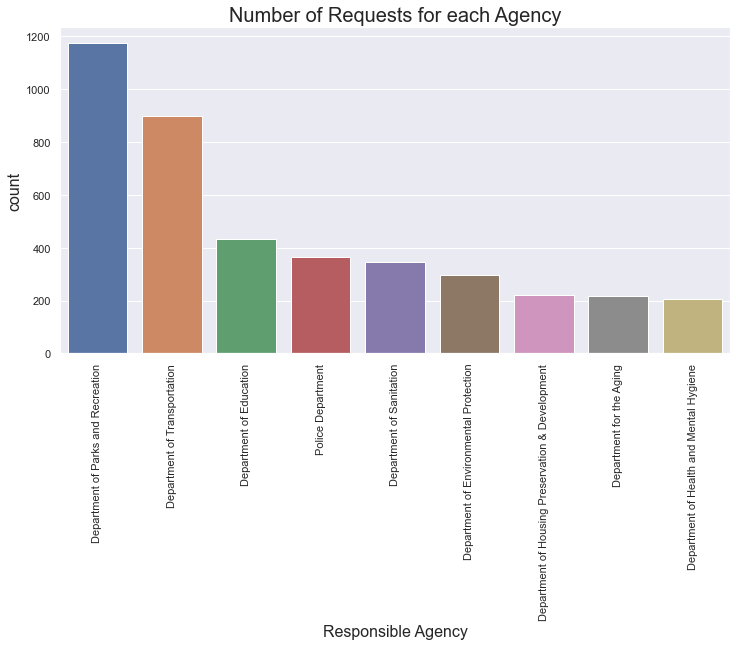

In [34]:
sns.set_theme(style="darkgrid")
plt.figure(figsize = (12,6))
plt.title('Number of Requests for each Agency', fontsize=20)
plt.xlabel('Responsible Agency', fontsize=16);
plt.ylabel('Count', fontsize=16);
ax = sns.countplot(x="Responsible Agency", data=df,order = df["Responsible Agency"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

**From the bar plot, we can see this dataset is an inbalanced dataset as there are over 1000 samples in the Department of Parks and Recreation class and only around 200 examples in the last three classes. To make sure we have enough sample for the classification model, oversampleing method is used to make this dataset evenly distributed in each class. imblearn is a python library can help us do this.**

In [35]:
# transform the dataset
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df.iloc[:,:-1], df['Responsible Agency'])

df = pd.concat([X_res, y_res], axis=1)

In [36]:
df.groupby('Responsible Agency').size()

Responsible Agency
Department for the Aging                            1175
Department of Education                             1175
Department of Environmental Protection              1175
Department of Health and Mental Hygiene             1175
Department of Housing Preservation & Development    1175
Department of Parks and Recreation                  1175
Department of Sanitation                            1175
Department of Transportation                        1175
Police Department                                   1175
dtype: int64

**After the data is resampled, this dataset has 1175 samples in each class.**

<span style="color:green;font-size:xx-large">Data Cleaning for Modelling</span>

In [37]:
#look how dirty the texts are
df['Explanation '].values

array(['Construct paved sidewalks on Loring Avenue between Drew Street and Amber Street.',
       'Provide a list of trench restoration work that is proposed for CB5 and conduct a survey to determine those areas that are in need based on failed surface work that was done in the past.',
       'Develop a sanitation enforcement pilot program (SEPP) on 36 Avenue Commercial strip. (item-20)',
       ...,
       'NYPD officers should be provided with sensitivity training to deal with the rapidly evolving community. The training should encompass measures of bridging the gaps between old residents and new residents to prevent conflicts. Too often, the cultural differences between new residents and older residents lead to conflicts because of a lack of understanding of the culture that exists in our diverse, but rapidly gentrifying community. Officers assigned to our local precincts and PSA2 must be able to handle these delicate situations efficiently and without bias.',
       'Allocate fundi

In [38]:
#data cleaning 
df = df.reset_index(drop=True)
replace_by_space = re.compile('[/(){}\[\]\|@,;]')
remove = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    # lowercase text
    text = text.lower() 
    # replace some symbols by space
    text = replace_by_space.sub(' ', text) 
    # remove some symbols
    text = remove.sub('', text) 
    # remove stopwors from text
    text = ' '.join(word for word in text.split() if word not in stopwords_list) 
    return text
df['exp_clean'] = df['Explanation '].apply(clean_text)
df['exp_clean'].values

array(['construct paved sidewalks loring avenue drew street amber street',
       'provide list trench restoration work proposed cb5 conduct survey determine areas need based failed surface work done past',
       'develop sanitation enforcement pilot program sepp 36 avenue commercial strip item20',
       ...,
       'nypd officers provided sensitivity training deal rapidly evolving community training encompass measures bridging gaps old residents new residents prevent conflicts often cultural differences new residents older residents lead conflicts lack understanding culture exists diverse rapidly gentrifying community officers assigned local precincts psa2 must able handle delicate situations efficiently without bias',
       'allocate funding bulletproof vests flashlights 62nd precinct',
       'increase antidrug education programs community youth'],
      dtype=object)

<span style="color:green;font-size:xx-large">Feature Extraction - TF-IDF</span>

**TF-IDF assigns each word in a collection a weight based on its term frequency (TF) and inverse document frequency (IDF). Using this method, each word become a feature and the value is the word's TF-IDF value. These features then become the input of the classification models.**

In [40]:
description_list = df['exp_clean'].tolist()

# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df['Responsible Agency'])

agency_list = list(pd.get_dummies(df['Responsible Agency']))

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(description_list)


tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)


<span style="color:green;font-size:xx-large">Feature Extraction - TF-IDF - Train Test Split</span>

**The train-test split is used to split data in to training set and test set. Training set is used to train the model and test set is used to test the performance of the model trained. Random state is set to make sure the split is the same each time we run the code and to get similar result each time. 80% of the data is used as the training set and 20% of the data is used as the test set.**

In [41]:
train_x, test_x, train_y, test_y = train_test_split(x_train_tfidf, label, test_size=0.2, random_state = 42)

In [42]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((8460, 10361), (2115, 10361), (8460,), (2115,))

In [43]:
num_classes = len(np.unique(train_y))
num_features = train_x.shape[1]
num_classes,num_features

(9, 10361)

**We can see that there are 8460 samples in the training set and 2115 samples in the test set. There are around 10,000 words and their TF-IDF values used as the features for model training. The samples will be calssified into 9 classes based on these features.**

<span style="color:green;font-size:xx-large">Classification Model - Naive Bayes</span>

Naive Bayes is a conditional probability model, given a collection to be classified, if we represent the features of sample by a vector x=(x1,...,xn), it assigns to this instance probabilities:

$$ \Large P(Ck|x1,...,xn) $$

The sample will be labeled as the class with the highest probability.



In [44]:
clf_nb = MultinomialNB().fit(train_x, train_y)
y_score_nb = clf_nb.predict(test_x)

n_right = 0
for i in range(len(y_score_nb)):
    if y_score_nb[i] == test_y[i]:
        n_right += 1

print("Test Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))

acc_nb = n_right/float(len(test_y))

Test Accuracy: 94.09%


<span style="color:green;font-size:xx-large">Classification Model - Support Vector Machine</span>

**The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that classifies the data points and the plane should maximize the distance between data points of each class.**



In [45]:
from sklearn.svm import SVC
clf_svm = SVC(kernel='linear').fit(train_x, train_y)
y_score_svm = clf_svm.predict(test_x)

n_right = 0
for i in range(len(y_score_svm)):
    if y_score_svm[i] == test_y[i]:
        n_right += 1

print("Test Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))
acc_svm = n_right/float(len(test_y))

Test Accuracy: 97.87%


<span style="color:green;font-size:xx-large">Classification Model - Logistic Regression with Tensorflow</span>

For a multiclass classification problem, each document belongs to one of the classes. We want to learn the probability of a class (dependent variable) given the data point: 
$$ \Large p(y_n=i|x_n) $$  
We assume a linear transformation of Xn:
$$ \Large p(y_n=i|x_n) = SoftMax(Wi^TXn+bi)$$  
Two sets of model parameters Wi and bi need to be estimated by the model. 



In [47]:
def accuracy(predictions, labels):
    # Return % of correctly classified tweets
    return (100.0 * np.sum(np.argmax(predictions, axis=1) == np.squeeze(labels)) / predictions.shape[0])

In [48]:
def create_weight(shape):
    # creates and initializes a weight matrix of the specified size
    return tf.Variable( tf.truncated_normal(shape, stddev=0.01) )
def create_bias(shape):
    # creates and initializes a bias term of the specified size
    return tf.Variable( tf.constant(0.1, shape=shape) )

In [49]:
def all_nn_computations(X, weights, biases):
    return tf.matmul(X, weights) + biases

In [50]:
# Create a Tensorflow graph for multiclass logistic regression
graph_MLR = tf.Graph()

with graph_MLR.as_default():
    # (a) Input data
    #     Load the training, validation and test data into constants that are
    #     attached to the graph
    tf_train_data = tf.constant(train_x.toarray().astype(np.float32))  # use the small dataset
    tf_train_labels = tf.constant(np.squeeze(train_y).astype(np.int32))
    tf_test_data = tf.constant(test_x.toarray().astype(np.float32))
    
    # (b) Variables
    #     Indicate the parameters that we need to infer
    weights = create_weight( [num_features, num_classes] )
    biases = create_bias( [num_classes] )
    
    # (c) Computations
    #     Indicate the computations that we want to perform with the variables and data
    train_logits = all_nn_computations(tf_train_data, weights, biases)
    loss = tf.reduce_mean( tf.nn.sparse_softmax_cross_entropy_with_logits(logits=train_logits,labels=tf_train_labels) )
    
    # (d) Optimizer
    #     Indicate the optimization procedure that we want to use
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)
    
    # (e) Other tasks
    #     Compute predictions on training, test, and validation
    train_prediction = tf.nn.softmax( train_logits )
    test_prediction = tf.nn.softmax( all_nn_computations(tf_test_data, weights, biases) )

In [51]:
max_iterations = 2000
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
with tf.Session(graph=graph_MLR) as session:
    # 1. Initialize the weights and biases. This is a one-time operation
    tf.global_variables_initializer().run()
    print('Initialized')
    
    # 2. Run iterations of gradient descent
    for step in range(max_iterations):
        # Run the computations. We tell .run() that we want to run the optimizer
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        
        # Report the loss, training and validation accuracy every 100 iterations:
        if (step % 500 == 0):
            # Print the loss
            print('Loss at step %d: %f' % (step, l))
            # Obtain and print the accuracy on the training set
            print('  +Training accuracy: %.2f%%' % accuracy(predictions, train_y))
            # Obtain and print the accuracy on the validation set
            
    # 3. Accuracy on the test set
    #test_cate = test_prediction.eval()
    y_score_mlr = tf.argmax(input=test_prediction, axis=1).eval()
    acc_lr = accuracy(test_prediction.eval(), test_y)
    print('Test Accuracy: %.2f%%' % accuracy(test_prediction.eval(), test_y))

2022-05-13 11:46:38.395957: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialized
Loss at step 0: 2.197264
  +Training accuracy: 10.60%
Loss at step 500: 1.588760
  +Training accuracy: 90.93%
Loss at step 1000: 1.214770
  +Training accuracy: 91.84%
Loss at step 1500: 0.983784
  +Training accuracy: 92.43%
Test Accuracy: 91.35%


<span style="color:green;font-size:1em">The tensorflow logistic regression model training takes a lot of time and the computational cost is huge. I tried another logistic regression model in Keras which is faster.</span>

<span style="color:green;font-size:xx-large">Classification Model - Logistic Regression with Keras</span>

In [56]:
model_lr = Sequential()
model_lr.add(Dense(18, input_dim=train_x.shape[1], activation='relu'))
model_lr.add(Dense(9,activation='softmax'))  
model_lr.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model_lr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                186516    
                                                                 
 dense_1 (Dense)             (None, 9)                 171       
                                                                 
Total params: 186,687
Trainable params: 186,687
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
epochs=200
batch_size=64
train_x = train_x.toarray()
history_lr = model_lr.fit(train_x, train_y, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 7614 samples, validate on 846 samples
Epoch 1/200
7614/7614 [==============================] - 1s 105us/sample - loss: 2.1959 - acc: 0.1327 - val_loss: 2.1942 - val_acc: 0.1395
Epoch 2/200
1856/7614 [======>.......................] - ETA: 0s - loss: 2.1950 - acc: 0.1455

/Users/wangyifan/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7614/7614 [==============================] - 0s 63us/sample - loss: 2.1935 - acc: 0.1512 - val_loss: 2.1911 - val_acc: 0.1454
Epoch 3/200
7614/7614 [==============================] - 0s 58us/sample - loss: 2.1905 - acc: 0.1660 - val_loss: 2.1879 - val_acc: 0.1560
Epoch 4/200
7614/7614 [==============================] - 0s 60us/sample - loss: 2.1869 - acc: 0.1996 - val_loss: 2.1842 - val_acc: 0.1832
Epoch 5/200
7614/7614 [==============================] - 0s 62us/sample - loss: 2.1828 - acc: 0.2432 - val_loss: 2.1801 - val_acc: 0.2364
Epoch 6/200
7614/7614 [==============================] - 0s 60us/sample - loss: 2.1785 - acc: 0.2854 - val_loss: 2.1759 - val_acc: 0.3298
Epoch 7/200
7614/7614 [==============================] - 0s 63us/sample - loss: 2.1740 - acc: 0.3504 - val_loss: 2.1714 - val_acc: 0.3723
Epoch 8/200
7614/7614 [==============================] - 0s 62us/sample - loss: 2.1694 - acc: 0.4016 - val_loss: 2.1668 - val_acc: 0.4279
Epoch 9/200
7614/7614 [=======================

7614/7614 [==============================] - 0s 60us/sample - loss: 1.6374 - acc: 0.8621 - val_loss: 1.6455 - val_acc: 0.8629
Epoch 62/200
7614/7614 [==============================] - 0s 58us/sample - loss: 1.6193 - acc: 0.8647 - val_loss: 1.6276 - val_acc: 0.8664
Epoch 63/200
7614/7614 [==============================] - 1s 79us/sample - loss: 1.6010 - acc: 0.8670 - val_loss: 1.6094 - val_acc: 0.8700
Epoch 64/200
7614/7614 [==============================] - 1s 72us/sample - loss: 1.5824 - acc: 0.8688 - val_loss: 1.5924 - val_acc: 0.8700
Epoch 65/200
7614/7614 [==============================] - 0s 60us/sample - loss: 1.5638 - acc: 0.8691 - val_loss: 1.5740 - val_acc: 0.8747
Epoch 66/200
7614/7614 [==============================] - 0s 63us/sample - loss: 1.5449 - acc: 0.8746 - val_loss: 1.5555 - val_acc: 0.8759
Epoch 67/200
7614/7614 [==============================] - 0s 60us/sample - loss: 1.5259 - acc: 0.8730 - val_loss: 1.5368 - val_acc: 0.8794
Epoch 68/200
7614/7614 [================

Epoch 120/200
7614/7614 [==============================] - 1s 87us/sample - loss: 0.6989 - acc: 0.9303 - val_loss: 0.7435 - val_acc: 0.9102
Epoch 121/200
7614/7614 [==============================] - 1s 70us/sample - loss: 0.6892 - acc: 0.9310 - val_loss: 0.7347 - val_acc: 0.9113
Epoch 122/200
7614/7614 [==============================] - 1s 68us/sample - loss: 0.6797 - acc: 0.9328 - val_loss: 0.7258 - val_acc: 0.9113
Epoch 123/200
7614/7614 [==============================] - 0s 60us/sample - loss: 0.6703 - acc: 0.9326 - val_loss: 0.7169 - val_acc: 0.9113
Epoch 124/200
7614/7614 [==============================] - 1s 68us/sample - loss: 0.6611 - acc: 0.9342 - val_loss: 0.7081 - val_acc: 0.9113
Epoch 125/200
7614/7614 [==============================] - 0s 61us/sample - loss: 0.6522 - acc: 0.9338 - val_loss: 0.6993 - val_acc: 0.9125
Epoch 126/200
7614/7614 [==============================] - 0s 63us/sample - loss: 0.6434 - acc: 0.9343 - val_loss: 0.6911 - val_acc: 0.9113
Epoch 127/200
7614/7

7614/7614 [==============================] - 1s 69us/sample - loss: 0.3548 - acc: 0.9538 - val_loss: 0.4163 - val_acc: 0.9267
Epoch 179/200
7614/7614 [==============================] - 1s 69us/sample - loss: 0.3514 - acc: 0.9543 - val_loss: 0.4137 - val_acc: 0.9267
Epoch 180/200
7614/7614 [==============================] - 1s 73us/sample - loss: 0.3479 - acc: 0.9557 - val_loss: 0.4099 - val_acc: 0.9291
Epoch 181/200
7614/7614 [==============================] - 1s 75us/sample - loss: 0.3447 - acc: 0.9557 - val_loss: 0.4073 - val_acc: 0.9291
Epoch 182/200
7614/7614 [==============================] - 1s 81us/sample - loss: 0.3414 - acc: 0.9559 - val_loss: 0.4036 - val_acc: 0.9291
Epoch 183/200
7614/7614 [==============================] - 1s 75us/sample - loss: 0.3382 - acc: 0.9557 - val_loss: 0.4007 - val_acc: 0.9314
Epoch 184/200
7614/7614 [==============================] - 1s 73us/sample - loss: 0.3350 - acc: 0.9565 - val_loss: 0.3985 - val_acc: 0.9267
Epoch 185/200
7614/7614 [=========

In [58]:
y_lr_matrix = model_lr.predict(test_x)
y_score_lr = np.argwhere(y_lr_matrix==np.amax(y_lr_matrix,1, keepdims=True))
y_score_lr = list(map(tuple, y_score_lr))
y_score_lr = np.array([x[1] for x in y_score_lr])
#y_score_lr

/Users/wangyifan/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [59]:
acc_lr = model_lr.evaluate(test_x,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_lr[0],acc_lr[1]))

Test set
  Loss: 0.361
  Accuracy: 0.941


In [60]:
acc_lr = acc_lr[1]

<IPython.core.display.Javascript object>


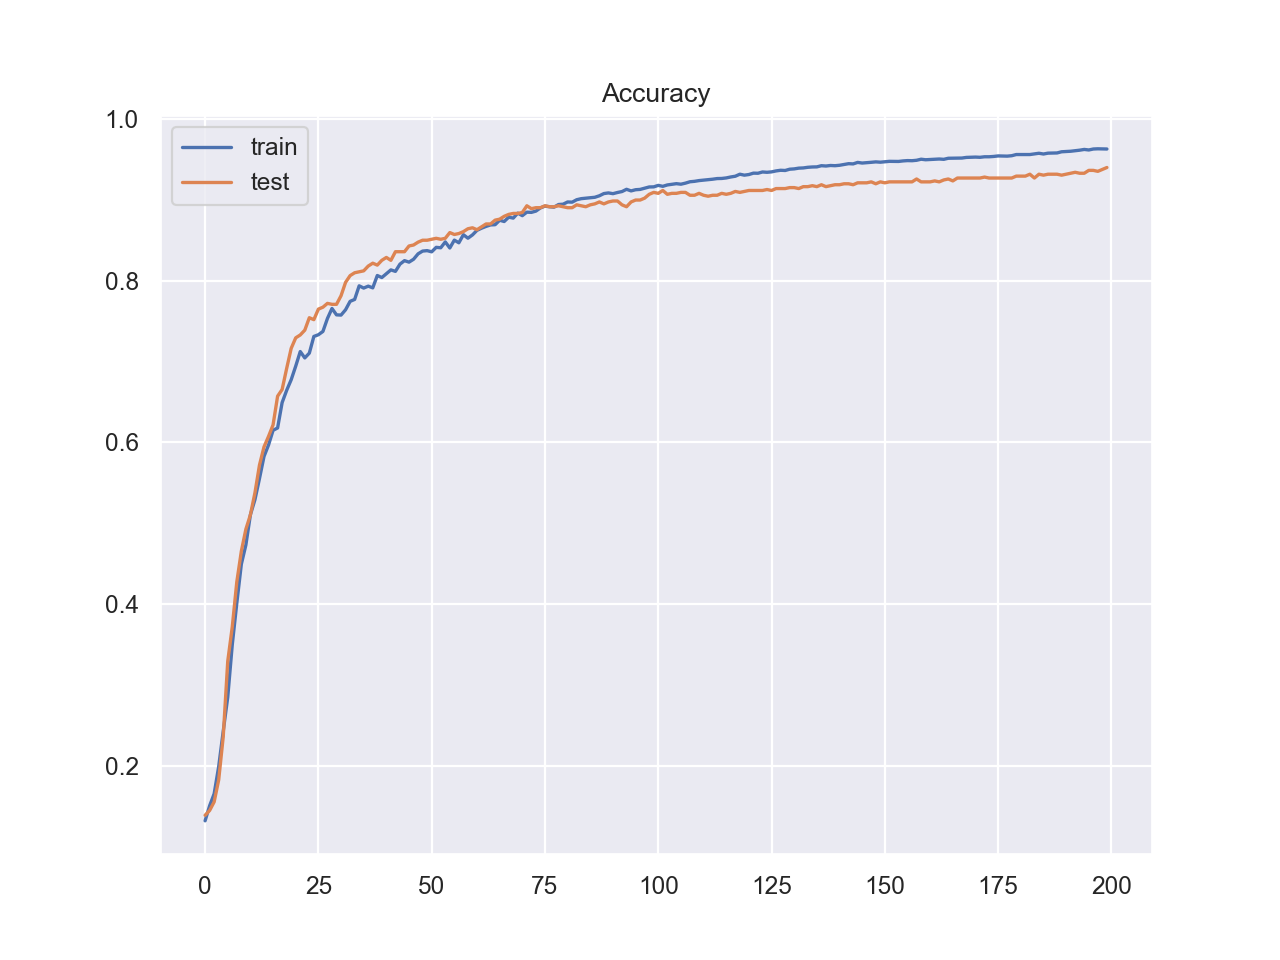

In [66]:
figure(figsize=(8, 6), dpi=80)
plt.title('Accuracy')
plt.plot(history_lr.history['acc'], label='train')
plt.plot(history_lr.history['val_acc'], label='test')
plt.legend()
plt.show()

<span style="color:green;font-size:1em">All these three models that take the TF-IDF representation as input performs well. However, there are some drawbacks of these models and TF-IDF. Firstly, TF-IDF transforms each word to feature independently, thus, word with similar meanings become completely different features. Another shortcoming is that TF-IDF and these models ignore the order of word in each sentence which is very importance in natural language. Thus, I decided to use a more complicated model to sovle these issues.</span>


<span style="color:green;font-size:xx-large">Classification Model - Word-Embedding+CNN+LSTM</span>

Word embedding is a method that represent each word by a vector where word with similar meaning have similar vector and the similarity between words could be directly interpreted. This method is better than TF-IDF as it takes the meaning of each word into consideration.


LSTM is an updated version of RNN to overcome the vanishing gradient problem. Using LSTM we can overcome the issue of processing each input independently and keep memory between inputs which in essencial for language models.
Below is the architecture of LSTM.

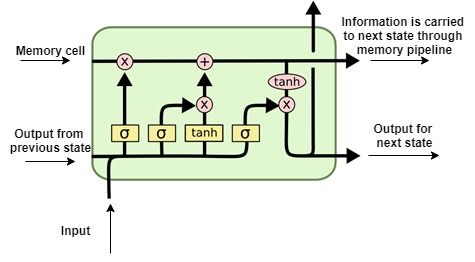

Image reference: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

There are three gates in LSTM, the forget gate, the input gate, and the output gate which controls how much information from the last instance should be kept, how much new information should be included and what is the output in this instance. The memory cell at the top helps to carry the information from last time instance to the next time instance. Information can be added or removed from the memory sell with the gate values. 

However, LSTM(RNN) are slow to train thus CNN model is applied before we use LSTM. A deep learning CNN model will pass feature matrix through a series of convolution layers with filters, activation function layers, Pooling layers, fully connected layers and apply some activation function such as Sigmoid or Softmax function to classify an object. CNN allow us to work with inputs of variable sizes and reduce the dimentionality.

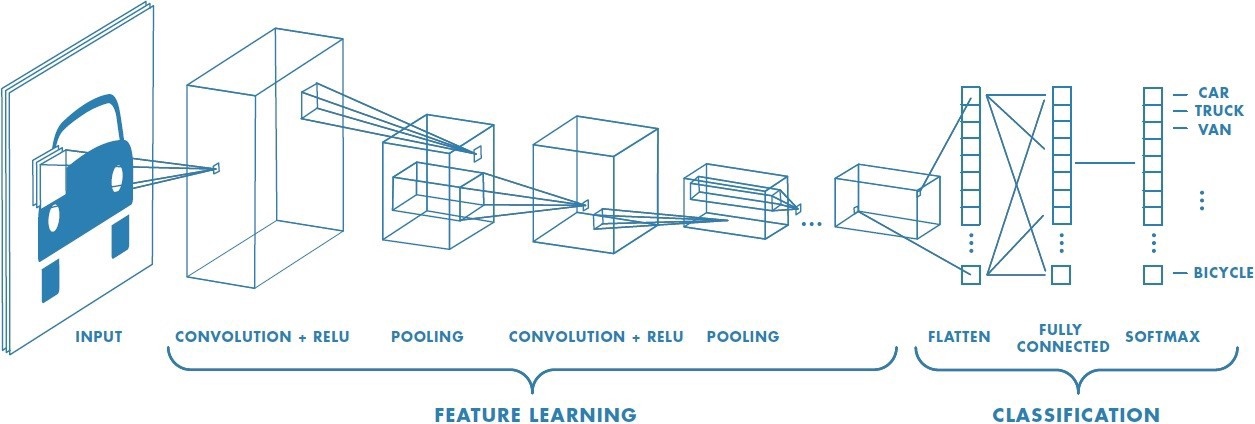

Image reference: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [68]:
df['len'] = df['exp_clean'].apply(lambda x: len(x))

In [69]:
df['len'].describe()

count    10575.000000
mean       207.933901
std        144.202870
min         13.000000
25%         94.000000
50%        167.000000
75%        288.000000
max        677.000000
Name: len, dtype: float64

In [70]:
# The maximum number of words to be used. (most frequent)
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['exp_clean'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10388 unique tokens.


In [71]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['exp_clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10575, 300)


In [72]:
Y = pd.get_dummies(df['Responsible Agency']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10575, 9)


In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8460, 300) (8460, 9)
(2115, 300) (2115, 9)


In [74]:
# create the model
model_lstm = Sequential()
#embedding layer
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
#convolutional layer
model_lstm.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#pooling layer
model_lstm.add(MaxPooling1D(pool_size=2))
#lstm layer
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(9, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm.summary())




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          100000    
                                                                 
 conv1d (Conv1D)             (None, 300, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 32)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 9)                 909       
                                                                 
To

In [75]:
epochs = 30
batch_size = 64

history_lstm = model_lstm.fit(X_train, Y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', 
                    patience=3, min_delta=0.0001)])


Train on 7614 samples, validate on 846 samples
Epoch 1/30
7614/7614 [==============================] - 22s 3ms/sample - loss: 1.6152 - acc: 0.4433 - val_loss: 0.7133 - val_acc: 0.8002
Epoch 2/30
7614/7614 [==============================] - 27s 4ms/sample - loss: 0.5119 - acc: 0.8450 - val_loss: 0.2594 - val_acc: 0.9374
Epoch 3/30
7614/7614 [==============================] - 21s 3ms/sample - loss: 0.3026 - acc: 0.9121 - val_loss: 0.2051 - val_acc: 0.9492
Epoch 4/30
7614/7614 [==============================] - 19s 3ms/sample - loss: 0.2285 - acc: 0.9322 - val_loss: 0.1883 - val_acc: 0.9492
Epoch 5/30
7614/7614 [==============================] - 19s 2ms/sample - loss: 0.1873 - acc: 0.9437 - val_loss: 0.1699 - val_acc: 0.9563
Epoch 6/30
7614/7614 [==============================] - 21s 3ms/sample - loss: 0.1653 - acc: 0.9506 - val_loss: 0.1608 - val_acc: 0.9527
Epoch 7/30
7614/7614 [==============================] - 19s 2ms/sample - loss: 0.1420 - acc: 0.9560 - val_loss: 0.1399 - val_acc: 0

In [76]:
y_lstm_matrix = model_lstm.predict(X_test)
y_score_lstm = np.argwhere(y_lstm_matrix==np.amax(y_lstm_matrix,1, keepdims=True))
y_score_lstm = list(map(tuple, y_score_lstm))
y_score_lstm = np.array([x[1] for x in y_score_lstm])
y_score_lstm

array([2, 3, 6, ..., 8, 0, 8])

In [77]:
accr_lstm = model_lstm.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_lstm[0],accr_lstm[1]))

Test set
  Loss: 0.174
  Accuracy: 0.953


In [78]:
acc_lstm = accr_lstm[1]

<IPython.core.display.Javascript object>


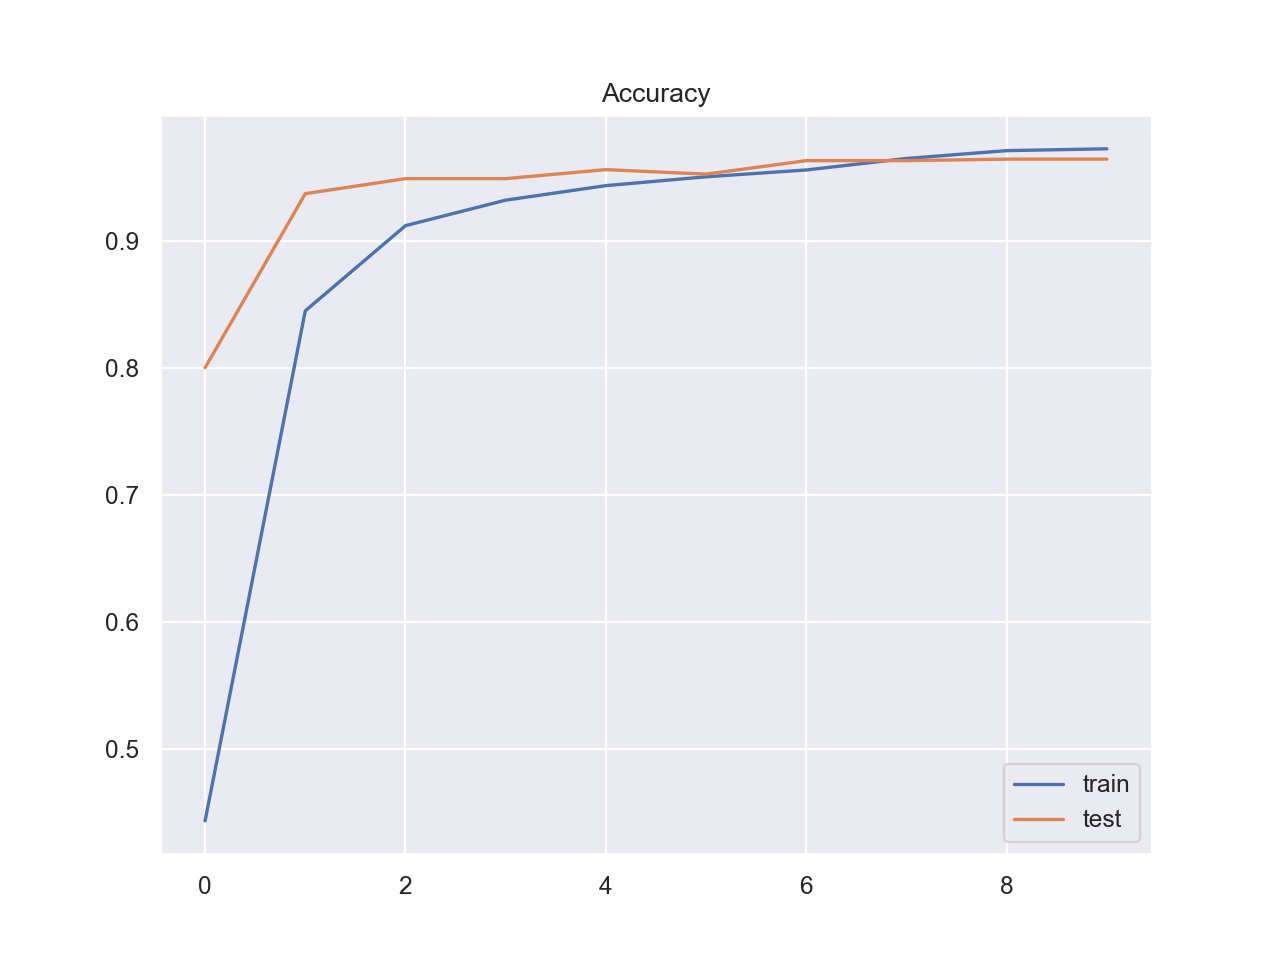

In [83]:
figure(figsize=(8, 6), dpi=80)
plt.title('Accuracy')
plt.plot(history_lstm.history['acc'], label='train')
plt.plot(history_lstm.history['val_acc'], label='test')
plt.legend()
plt.show()

<span style="color:green;font-size:xx-large">Result Analysis of NB, SVM, MLR, CNN+LSTM</span>

<span style="color:green;font-size:1.5em">Accuracies</span>


In [88]:
print("The accuracy of Naive Bayes on the test set is %.2f%%" % (acc_nb*100))
print("The accuracy of SVM on the test set is %.2f%%" % (acc_svm*100))
print("The accuracy of Logistic Regression on the test set is %.2f%%" % (acc_lr*100))
print("The accuracy of CNN+LSTM on the test set is %.2f%%" % (acc_lstm*100))

The accuracy of Naive Bayes on the test set is 94.09%
The accuracy of SVM on the test set is 97.87%
The accuracy of Logistic Regression on the test set is 94.14%
The accuracy of CNN+LSTM on the test set is 95.32%


<span style="color:green;font-size:1.5em">Samples Misclassified by all the Models</span>

In [90]:
agency_list = list(pd.get_dummies(df['Responsible Agency']))

In [91]:
predictions = pd.DataFrame(
    {'Naive_Bayes': [agency_list[i] for i in y_score_nb.tolist()],
     'Support_Vector_Machine': [agency_list[i] for i in y_score_svm.tolist()],
     'Logistic_Regression': [agency_list[i] for i in y_score_mlr.tolist()],
     'CNN_LSTM': [agency_list[i] for i in y_score_lstm.tolist()],
     'actual': [agency_list[i] for i in test_y.tolist()]
    })

In [94]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(df['Explanation '],df['Responsible Agency'], test_size = 0.20, random_state = 42)

In [95]:
predictions['explanation'] = list(X_test1)

In [96]:
#find the requests that are incorrectly predicted by all models
predictions[(predictions['Naive_Bayes']!=predictions['actual'])&
            (predictions['Support_Vector_Machine']!=predictions['actual'])&
            (predictions['Logistic_Regression']!=predictions['actual'])&
            (predictions['CNN_LSTM']!=predictions['actual'])
           ]

,Naive_Bayes,Support_Vector_Machine,Logistic_Regression,CNN_LSTM,actual,explanation
107,Department of Transportation,Department of Parks and Recreation,Department of Parks and Recreation,Department of Parks and Recreation,Department of Sanitation,We request additional trash receptacles in the following locations: -East 165th street between Grant and the Grand Concourse -East 169th and Clay Avenue -Grand Concourse / E 156th Street (west side Franz Sigel Park) -Grand Concourse / Across from to 700 -Grand Concourse (west side Franz Sigel Park) -Grand Concourse / Across from to 770 -Grand Concourse (west side Franz Sigel Park) -Grand Concourse / Across from to 770 -Grand Concourse (west side Franz Sigel Park) -Grand Concourse / Across from to 790 -Grand Concourse (west side Franz Sigel Park) -165th Street / Between Jerome Avenue and River Avenue (mid-block Mullaly Park entrance N) -165th Street / Between Jerome Avenue and River Avenue (mid-block Mullaly Park entrance N) 166th Street and Grand Concourse (SW Corner)
129,Police Department,Department of Parks and Recreation,Department of Parks and Recreation,Department of Parks and Recreation,Department of Transportation,Pershing Square West has been repaired and looks great; it would be great if the rest of the Plazas could follow suit.
136,Department of Education,Department of Education,Department of Education,Department of Education,Department of Transportation,Build out crosswalks that serve P.S./I.S. 89.
196,Department of Environmental Protection,Department of Environmental Protection,Department of Environmental Protection,Department of Environmental Protection,Department of Transportation,"Create/enhance an ongoing program in the department to promote/require green infrastructure initiatives throughout the district, but particularly in areas of greatest pedestrian traffic such as around Penn Station, Herald and Greeley Squares, and Times Square. These green infrastructure initiatives should include rain gardens, stormwater management, greenstreets, etc. to create a variety of sustainable green infrastructure practices in public and private streetscapes in the district."
200,Department of Transportation,Department of Transportation,Department of Transportation,Department of Transportation,Department of Parks and Recreation,"Install high netting around Douglaston Golf Course on the Douglaton Parkway side of the course, western boundary between 65 & 69 Avenues to stop errant golf balls from falling on homes and cars. Netting was installed on the Commonwealth Blvd. side of the course."
301,Department of Environmental Protection,Department of Environmental Protection,Department of Environmental Protection,Department of Environmental Protection,Department of Transportation,Street is sinking around catch basins along this strip
372,Department of Transportation,Department of Transportation,Department of Transportation,Department of Transportation,Police Department,"Improve and modernize security infrastructure and devices in the vicinity of the New York Stock Exchange which includes Wall and Broad Streets. The Downtown Alliance has initiated a study of the area, but capital funds are needed to update the infrastructure."
532,Department of Transportation,Department of Transportation,Department of Transportation,Department of Transportation,Department of Parks and Recreation,Replace sidewalks and curbs on East 4th Street between Ft. Hamilton Parkway and Caton Avenue at the community garden. The adjacent property owner in NYC.
563,Department of Parks and Recreation,Department of Parks and Recreation,Department of Parks and Recreation,Department of Parks and Recreation,Department of Transportation,Provide funding to supplement maintenance and upkeep at Hudson River Park.
602,Department of Education,Department of Education,Department of Education,Department of Education,Department of Parks and Recreation,create and fund water safety and swim programs for NYC school age children to prevent dr

<span style="color:green;font-size:1.5em">Samples Misclassified by TF-IDF Models (NB, SVM, LR) and Correctly Classified by CNN+LSTM</span>

In [97]:
predictions[(predictions['Naive_Bayes']!=predictions['actual'])&
            (predictions['Support_Vector_Machine']!=predictions['actual'])&
            (predictions['Logistic_Regression']!=predictions['actual'])&
            (predictions['CNN_LSTM']==predictions['actual'])
           ]

,Naive_Bayes,Support_Vector_Machine,Logistic_Regression,CNN_LSTM,actual,explanation
117,Department of Transportation,Department of Transportation,Department of Transportation,Department of Parks and Recreation,Department of Parks and Recreation,"The segment of Queens Boulevard from 90th Street to 77th Street is in need of tree maintenance/ pruning as the majority of trees along this stretch of road are dead and/or dying. In conjunction with the Queens Boulevard Safety Program in which bike lanes were implemented along this boulevard, the added benefit from a decrease in the carbon foot prints along the corridor would be a huge asset to the bike riders, and pedestrians alike. Funding is being requested to look into the maintenance of trees along the boulevard. Additionally, trees surrounding Newtown Field (57 Ave and 92 Street) are in dire shape. This same initiative should be extended to this stretch of road adjacent to Queens Boulevard."
901,Department of Transportation,Department of Transportation,Department of Transportation,Department of Parks and Recreation,Department of Parks and Recreation,Repave the sidewalk along the East side of Bainbridge Avenue from the West bound lanes of Mosholu Parkway to Mosholu Parkway North Service Road. The sidewalk is cracked and dangerous for pedestrians.
1277,Department of Environmental Protection,Department of Transportation,Department of Health and Mental Hygiene,Department of Parks and Recreation,Department of Parks and Recreation,Build a community center to serve the increased population east of Broadway in Lower Manhattan.
1928,Police Department,Police Department,Police Department,Department of Transportation,Department of Transportation,Transfer of budget funds to return parking and traffic enforcement to DOT control instead of NYPD (as had been done in the 1990s)


<span style="color:green;font-size:xx-large">Ensemble Model</span>

**To combine all the four models and get the best prediction result, we use the essemble method and let the models vote to get the final classification result.**

In [101]:
predictions['recommended department'] = predictions.mode(axis=1, numeric_only=False, dropna=True)[0]

In [106]:
acc_ensemble = len(predictions[predictions['actual']==predictions['recommended department']])/len(predictions)

In [107]:
print("The accuracy of the Ensemble Model on the test set is %.2f%%" % (acc_ensemble*100))

The accuracy of the Ensemble Model on the test set is 97.73%


<span style="color:green;font-size:xx-large">Test a New Request with the FINAL ENSEMBLE MODEL!!!</span>

In [98]:
def get_prediction(new_request):
    clean_request = clean_text(new_request)
    new_counts = count_vect.transform([clean_request])
    new_tfidf = tfidf_transformer.transform(new_counts)
    nb_pred = clf_nb.predict(new_tfidf)
    svm_pred = clf_svm.predict(new_tfidf)
    #nb_pred
    nb_pred = agency_list[nb_pred[0]]
    #svm_pred
    svm_pred = agency_list[svm_pred[0]]
    #lr_pred
    lr_pred = model_lr.predict(new_tfidf)
    lr_pred = agency_list[np.argmax(lr_pred)]
    #lstm_pred
    seq = tokenizer.texts_to_sequences([clean_request])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    lstm_pred = model_lstm.predict(padded)
    lstm_pred = agency_list[np.argmax(lstm_pred)]
    print('Naive Bayes Predicted Responsible Agency: ', nb_pred)
    print('\n')
    print('Support Vector Machine Predicted Responsible Agency: ', svm_pred)
    print('\n')
    print('Logstic Regression Predicted Responsible Agency: ', lr_pred)
    print('\n')
    print('CNN+LSTM Predicted Responsible Agency: ', lstm_pred)
    print('\n')
    results=[nb_pred,svm_pred,lr_pred,lstm_pred]
    recommended_Responsible_Agency = max(set(results), key=results.count)
    print('Recommended Predicted Responsible Agency: ', recommended_Responsible_Agency)
    return recommended_Responsible_Agency

In [99]:
get_prediction('traffic light need to be repaired')

Naive Bayes Predicted Responsible Agency:  Department of Transportation


Support Vector Machine Predicted Responsible Agency:  Department of Transportation


Logstic Regression Predicted Responsible Agency:  Department of Transportation


CNN+LSTM Predicted Responsible Agency:  Department of Transportation


Recommended Predicted Responsible Agency:  Department of Transportation


'Department of Transportation'